# Solving Bloch Eigenproblems with FenicsX

Josh Tempelman

University of Illinois at Urbana Champaign

jrt7@illinois.edu


## Problem Defintion:
Find the eigensolutions to the Bloch-periodic wave equation. We consider a domain $\Omega \in[0,a]\times[0,a]$, where $a$ is the characteristic unit cell length, that satisfies

\begin{align}
	&\rho \ddot{u} - c^2\nabla^2 u  = 0\\
	&u(0,y) = u(a,y)e^{i k_xa} \ \ \text{on} \ 0<y<a\\
	&u(x,0) = u(x,a)e^{i k_ya} \ \ \text{on} \ 0<x<a
\end{align}

In [1]:
# ################################################## #
# Genearal imports                                   #
# ################################################## #
import numpy as np
import matplotlib.pyplot as plt
import time
import os

# ################################################## #
# Imports for plotting                               #
# ################################################## #
import matplotlib.pyplot as plt
from dolfinx.io import gmshio
import pyvista
pyvista.start_xvfb()

# ################################################## #
# Imports for the meshing                            #
# ################################################## #
import gmsh
from MeshFunctions      import get_mesh_SquareSpline,get_mesh_SquareMultiSpline
from dolfinx.plot       import create_vtk_mesh
from dolfinx.io         import XDMFFile
from dolfinx.io.gmshio  import model_to_mesh
from dolfinx.io         import gmshio

# ################################################## #
# Imports for finite element modeling                #
# ################################################## #
from mpi4py import MPI
import dolfinx_mpc
import dolfinx
from dolfinx.fem    import Function, FunctionSpace, VectorFunctionSpace
from dolfinx.mesh   import create_unit_square 
from dolfinx.mesh   import create_rectangle
from dolfinx.fem    import form
from dolfinx.fem.petsc import assemble_matrix
from dolfinx    import plot
from dolfinx.io import gmshio
from mpi4py     import MPI
from dolfinx    import fem
from ufl        import TrialFunction, TestFunction, grad, dx, dot, nabla_div, Identity, nabla_grad, inner, sym
from petsc4py.PETSc import ScalarType
from slepc4py   import SLEPc
from petsc4py   import PETSc
from typing     import List
import scipy.sparse
from scipy.sparse.linalg import eigsh
from scipy import sparse

## Define the parameters of the mesh

Here we set parameters of the problem. The first step is to pick a geometry of our 2D unit cell. This code currenlty supports square unit cells.
    
To parameterize $\mathcal{D}(\textbf{x})$, the inner void topology is determined by fitting a radially periodic B-spline curve to a set of design points $x_i$ and $y_i$.
The $x_i$ and $y_i$ coordinates of each design point are determined by design variable $r_i$ via $x_i = r_i\cos\theta_i$ and $y_i=r_i\sin\theta_i$, where $\theta_i$ ensures equidistant angles between design points.
Two design schemes are explored: a 3-variable ($\textbf{x}\in\mathbb{R}^3$) and 6-variable ($\textbf{x}\in\mathbb{R}^6$) scheme.  In the 3-variable scheme, the design points are confined to a subquadrant of $0\leq\theta\leq\pi/4$ and are radially rotated around the unit circle with 8-fold symmetry to recover the complete set of design points. In the 6-variable scheme, the design domain is expanded to $0\leq\theta\leq\pi/2$ and 4-fold rotations are applied. Figure~\ref{FIG:Dvec_EX} depicts representative examples of the deisgn vector space, quadrant rotations, spline curve, and resulting dispersion diagrams for both the 3- and 6-variable schemes.

Here is an example of a design vecotor that is rotated 4 times (Nquads = 3) and the spline curve that results from it

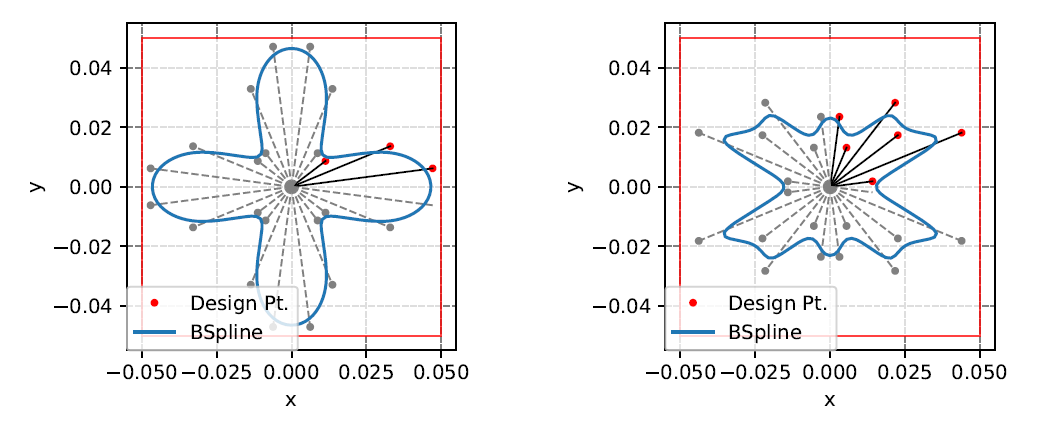

It is suggesgted to use 4-fold symmetry (Nquad  = 4) to reduce the number of high-symmetry points required to construct the dispersion diagrams

We have built a `gmsh` function to parameterize a method based on:


    a_len   -            Charecterstic unit cell length (primitive basis)

    r        -           vector of points to fit spline to

    Nquads    -          Number of quadrants to repeat spline through (radially)
    
    offset     -         Offset angle for inclusion geometry

    iscut       -        Choose if inclusion is void or an filled

    refinement_level -   Choose how much denser mesh gets around refinement field

    refinement_dist  -   Maximum distance of refinement field from refined edges
    
    isrefined        -   Choose whether or not to refine mesh around internal edges

    meshalg          -   Meshing algorithm for gmsh to use

In [121]:
start = time.time()
a_len = .1
r           = np.array([1,.2,.9])*a_len*.95
offset      = 0

da                  =   a_len/15
meshalg             =   6
refinement_level    =   3
refinement_dist     =   a_len/10
Nquads      = 4

isrefined = True    # Local refinement 
cut = True         # Void or inclusion

## Define the parameters of the physcial domain

Here c and rho are spped of sound and density. If cut is False, then there are two seperate physcial domains and these must be lists where the entries correspond to the two domains. If cut is True, then the inclusion is not considered in the mesh and c and rho are scalars

In [106]:
if not cut:
    c           = [1500,5100]
    rho         = [1e3,7e3]
else:
    c           = [30]
    rho         = [1.2]

## Generate the mesh

The file `Mesh_Functions` contains `get_mesh_SquareSpline`, which takes the mesh paremetrs as inputs, and creates a mesh using the `gmsh` api

In [122]:
######################################################################
#                  Generate a mesh with one inlsuion                 #
######################################################################
meshalg                 = 6
gmsh.model, xpt, ypt    = get_mesh_SquareSpline(a_len ,da,r,Nquads,offset,meshalg,
                                                refinement_level,refinement_dist,
                                                isrefined = isrefined, cut = cut)

Info    : Clearing all models and views...
Info    : Done clearing all models and views
[(1, 1), (1, 2), (1, 3), (1, 4), (1, 5)]
 --------- ERROR HERE --------------
Info    : Error in transformation from curve 2 (19-17) to 4 (20-19) (minimal transformed node distances 0 0.141421, tolerance 1.41563e-09)
Info    : Error in transformation from curve 3 (18-20) to 1 (17-18) (minimal transformed node distances 0.223607 0.1, tolerance 1.41563e-09)
 --------- ERROR HERE --------------
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 20%] Meshing curve 2 (Line)
Info    : [ 40%] Meshing curve 3 (Line)
Info    : [ 60%] Meshing curve 4 (Line)
Info    : [ 80%] Meshing curve 5 (BSpline)
Info    : Done meshing 1D (Wall 0.0453528s, CPU 0.048522s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
to here
Info    : Done meshing 2D (Wall 0.0160617s, CPU 0.016202s)
Info    : 764 nodes 1521 elements


The mesh now needs to be convereted into a form dolfinx can read 

In [123]:
#################################################################
#            Import to dolfinx and save as xdmf                 #
#################################################################
mesh_comm = MPI.COMM_WORLD
model_rank = 0
mesh, ct, _ = model_to_mesh(gmsh.model, mesh_comm, model_rank, gdim=2)
with XDMFFile(MPI.COMM_WORLD, "mt.xdmf", "w") as xdmf:
    xdmf.write_mesh(mesh)
    xdmf.write_meshtags(ct)
t1 =  round(time.time()-start,3)
print('Generated Mesh in ' + str(t1)  + ' Seconds')    

Generated Mesh in 21.395 Seconds


We can visualize the mesh using `pyvista`


No module named 'trame'

Falling back to a static output.
  warnings.warn(



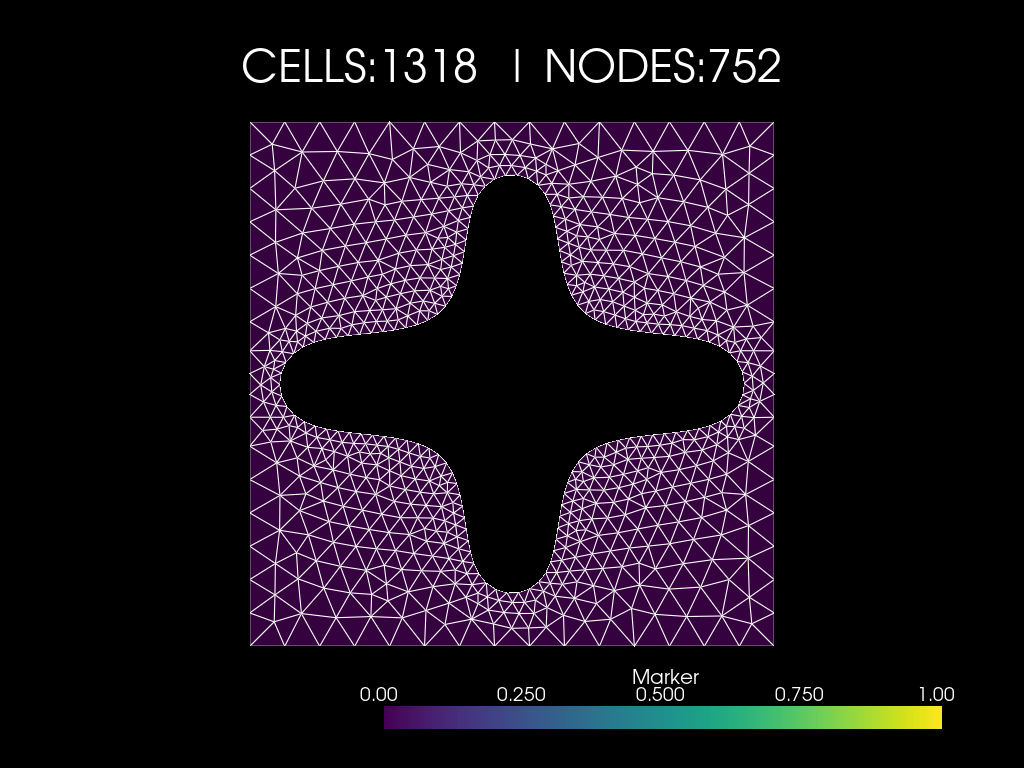

In [124]:
#################################################################
#              Plot the mesh                                    #
#################################################################
V = FunctionSpace(mesh,('CG',1))
v = Function(V)
plotter = pyvista.Plotter()
grid = pyvista.UnstructuredGrid(*create_vtk_mesh(mesh, mesh.topology.dim))
num_local_cells = mesh.topology.index_map(mesh.topology.dim).size_local
grid.cell_data["Marker"] = 1-ct.values[ct.indices<num_local_cells]
grid.set_active_scalars("Marker")
actor = plotter.add_mesh(grid, show_edges=True, line_width= 1, edge_color= 'w')
# actor = plotter.add_mesh(grid, style="wireframe", color= 'w', line_width=3)
plotter.set_background('black', top='black')
plotter.view_xy()
plotter.screenshot('Mesh.jpeg',window_size=[2000,1400])
plotter.add_title('CELLS:'+str(ct.values.shape[0])+ '  | NODES:'+str(v.vector[:].shape[0]))
plotter.show()


We can also recover the spline curve. The follow function returns the curve. The design vector is plotted as red dots and the rotated quadradnts are plotted in gray.

(-0.05500000000000001,
 0.05500000000000001,
 -0.05500000000000001,
 0.05500000000000001)

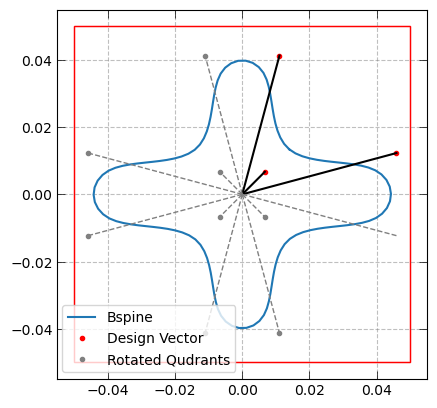

In [125]:
def GetSpline(gmsh):   
    # Get spline geometry from gmsh mesh
    node_interior = gmsh.model.mesh.getNodesForPhysicalGroup(1,5)[1]
    x_int       = node_interior[0::3]
    y_int       = node_interior[1::3]
    x_int       = np.concatenate([x_int,[x_int[0]]])
    y_int       = np.concatenate([y_int,[y_int[0]]])
    xi          = x_int - a_len/2
    yi          = y_int - a_len/2
    lxi         = len(xi)
    lxp         = len(xpt)
    xptnd       = np.array(xpt) - a_len/2
    yptnd       = np.array(ypt)- a_len/2
    lxp         = len(xptnd)
    xsv         = np.empty(xi.shape)
    SplineDat   = np.hstack( (xi.reshape(lxi,1), yi.reshape(lxi,1) ))  
    SplinePtDat = np.hstack( (xptnd.reshape(lxp,1), yptnd.reshape(lxp,1) ))  
    return SplinePtDat, SplineDat


x  = np.array(xpt) - a_len/2
y  = np.array(ypt) - a_len/2
SplinePtDat, SplineDat = GetSpline(gmsh)
# plt.scatter(SplinePtDat[:,0],SplinePtDat[:,1])
plt.plot(SplineDat[:,0],SplineDat[:,1])
plt.plot(x[0:int(len(xpt)/Nquads)], y[0:int(len(xpt)/Nquads)], ' .r')
plt.plot(x[int(len(xpt)/Nquads):-1], y[int(len(xpt)/Nquads):-1], '.', color = 'gray')
for j in range(len(xpt)):
    # plt.plot([0,x[r]], [0,y[r]],'k')
    if j<int(len(x)/Nquads):
        plt.plot([0,x[j]], [0,y[j]],'k')
    else:
        plt.plot([0,x[j]], [0,y[j]],'--', color = 'gray', linewidth = 1)
ax = plt.gca()
ax.add_patch( Rectangle( (-a_len/2,-a_len/2),a_len,a_len, facecolor="w" ,ec='r', alpha =.25,label='bangap'))
ax.add_patch( Rectangle( (-a_len/2,-a_len/2),a_len,a_len, facecolor="none" ,ec='r', alpha =1,label='bangap'))
plt.tick_params(direction='in', length=6, width=.5, colors='k',
        grid_color='k', grid_alpha=0.5, 
        bottom=True, top=True, left=True, right=True)
ax.grid(color='gray', linestyle='dashed')
plt.legend(['Bspine','Design Vector','Rotated Qudrants'],loc='lower right', bbox_to_anchor=(0.5, 0.0))
plt.axis('square')

We now define the function to create the periodic boundary, taken directly form (Link )

In [126]:
#################################################################
#       Function for multi point constraint                     #
#################################################################
def dirichlet_and_periodic_bcs(domain, functionspace, boundary_condition: List[str] = ["dirichlet", "periodic"], dbc_value = 0):
    """
    Function to set either dirichlet or periodic boundary conditions
    ----------
    boundary_condition
        First item describes b.c. on {x=0} and {x=1}
        Second item describes b.c. on {y=0} and {y=1}
    """
    
    fdim = domain.topology.dim - 1
    bcs             = []
    pbc_directions  = []
    pbc_slave_tags  = []
    pbc_is_slave    = []
    pbc_is_master   = []
    pbc_meshtags    = []
    pbc_slave_to_master_maps = []

    def generate_pbc_slave_to_master_map(i):
        def pbc_slave_to_master_map(x):
            out_x = x.copy() # was ist x.copy()?
            out_x[i] = x[i] - domain.geometry.x.max()
            return out_x
        return pbc_slave_to_master_map

    def generate_pbc_is_slave(i):
        return lambda x: np.isclose(x[i], domain.geometry.x.max())

    def generate_pbc_is_master(i):
        return lambda x: np.isclose(x[i], domain.geometry.x.min())

    # Parse boundary conditions
    for i, bc_type in enumerate(boundary_condition):
        
        if bc_type == "dirichlet":
            u_bc = fem.Function(functionspace)
            u_bc.x.array[:] = dbc_value # value of dirichlet bc needs to be passed into this function!

            def dirichletboundary(x):
                return np.logical_or(np.isclose(x[i], domain.geometry.x.min()), np.isclose(x[i], domain.geometry.x.max()))
            facets = locate_entities_boundary(domain, fdim, dirichletboundary)
            topological_dofs = fem.locate_dofs_topological(functionspace, fdim, facets)
            bcs.append(fem.dirichletbc(u_bc, topological_dofs))
        
        elif bc_type == "periodic":
            pbc_directions.append(i)
            pbc_slave_tags.append(i + 2)
            pbc_is_slave.append(generate_pbc_is_slave(i))
            pbc_is_master.append(generate_pbc_is_master(i))
            pbc_slave_to_master_maps.append(generate_pbc_slave_to_master_map(i))

            facets = dolfinx.mesh.locate_entities_boundary(domain, fdim, pbc_is_slave[-1])
            arg_sort = np.argsort(facets)
            pbc_meshtags.append(dolfinx.mesh.meshtags(domain,
                                          fdim,
                                          facets[arg_sort],
                                          np.full(len(facets), pbc_slave_tags[-1], dtype=np.int32)))

    # Create MultiPointConstraint object
    mpc = dolfinx_mpc.MultiPointConstraint(functionspace)
    
    N_pbc = len(pbc_directions)
    for i in range(N_pbc):
        if N_pbc > 1:
            def pbc_slave_to_master_map(x):
                out_x = pbc_slave_to_master_maps[i](x)
                idx = pbc_is_slave[(i + 1) % N_pbc](x)
                out_x[pbc_directions[i]][idx] = np.nan
                return out_x
        else:
            pbc_slave_to_master_map = pbc_slave_to_master_maps[i]

        if functionspace.num_sub_spaces == 0:
            mpc.create_periodic_constraint_topological(functionspace, pbc_meshtags[i],
                                            pbc_slave_tags[i],
                                            pbc_slave_to_master_map,
                                            bcs)
        else:
            for i in range(functionspace.num_sub_spaces):
                mpc.create_periodic_constraint_topological(functionspace.sub(i), pbc_meshtags[i],
                                                pbc_slave_tags[i],
                                                pbc_slave_to_master_map,
                                                bcs)
                
    if len(pbc_directions) > 1:
        # Map intersection(slaves_x, slaves_y) to intersection(masters_x, masters_y),
        # i.e. map the slave dof at (1, 1) to the master dof at (0, 0)
        def pbc_slave_to_master_map(x):
            out_x = x.copy()
            out_x[0] = x[0] - domain.geometry.x.max()
            out_x[1] = x[1] - domain.geometry.x.max()
            idx = np.logical_and(pbc_is_slave[0](x), pbc_is_slave[1](x))
            out_x[0][~idx] = np.nan
            out_x[1][~idx] = np.nan
            return out_x
        
        if functionspace.num_sub_spaces == 0:
            mpc.create_periodic_constraint_topological(functionspace, pbc_meshtags[1],
                                                pbc_slave_tags[1],
                                                pbc_slave_to_master_map,
                                                bcs)
            
        else:
            for i in range(functionspace.num_sub_spaces):
                mpc.create_periodic_constraint_topological(functionspace.sub(i), pbc_meshtags[1],
                                                    pbc_slave_tags[1],
                                                    pbc_slave_to_master_map,
                                                    bcs)
            
    mpc.finalize()
    return mpc, bcs

Assign Physical parameters to the mesh

In [127]:
if len(rho) > 1:
    # E.g., if more than one physical group assigned.
    # Assign material propoerties to each physical group.
    Q = FunctionSpace(mesh, ("DG", 0))
    E = Function(Q)
    Rho = Function(Q)    
    material_tags   = np.unique(ct.values)
    disk1_cells     = ct.find(1)
    disk2_cells     = ct.find(2)
    Rho.x.array[disk1_cells]    = np.full_like(disk1_cells, rho[0], dtype=ScalarType)
    Rho.x.array[disk2_cells]    = np.full_like(disk2_cells, rho[1], dtype=ScalarType)
    E.x.array[disk1_cells]      = np.full_like(disk1_cells,  c[0], dtype=ScalarType)
    E.x.array[disk2_cells]      = np.full_like(disk2_cells,  c[1], dtype=ScalarType)

else:
    Rho = rho[0]
    E   = c[0]


\begin{equation}
	{u}(\textbf{x},\textbf{k};t) = \tilde{{u}}e^{i(\textbf{k}\cdot\textbf{x} - \omega t)}
\end{equation}
into the periodic boundary value problem.
Defining a test function $\tilde{w}(\textbf{x},t)$ and trial function $\tilde{u}$, the weak for may be expressed as
\begin{equation}
	c^2\int_{\Omega} \langle \nabla w,\nabla u\rangle{\rm d}\Omega = \rho\int_{\Omega}w\ddot{u}{\rm d}\Omega.
\end{equation}
We assume a test function  to be a Bloch-periodic scalar field,$w = \tilde{w}e^{i(\textbf{k}^T\textbf{x}-\omega t)}$. Next, make use of the gradients of the Bloch-functions,
\begin{equation}
	\nabla(u)  = \left(\nabla(\tilde{u}) + i\tilde{u}\textbf{k}  \right)e^{i(\textbf{k}^T\textbf{x} -\omega t) }
\end{equation}
so that the variational equations take the form
\begin{equation}
	c^2\int_{\Omega} 
	\left[ \nabla(\tilde{w}) + i\tilde{w}\textbf{k} \right]^{\dagger}
	\left[ \nabla(\tilde{u}) + i\tilde{u}\textbf{k}  \right]
	{\rm d} \omega
	=\rho \int_{\Omega}\tilde{w}^{\dagger}\ddot{u}{\rm d}\Omega.
\end{equation}

where we assume a test function  to be a Bloch-periodic scalar field, $w = \tilde{w}e^{i(\textbf{k}^T\textbf{x}-\omega t)}$.



We set the weak form for mass first, since this does not depend on wave vector and therefor anly needs to be asembled once.

$$
\rho \int_{\Omega}\tilde{w}^{\dagger}\ddot{u}{\rm d}\Omega.
$$
 The following code evalutes the integral and assembles over each element,

$$
\mathbf{M} =	A_{e=1}^{n_{el}}  \int_{\Omega^e}  \rho\omega^2\tilde{\mathbf{w}}^e\tilde{\mathbf{u}}^e {\rm d}\Omega^e  
$$


In [113]:
#################################################################
#     Assign function space and constarint to mesh              #
#################################################################
V = FunctionSpace(mesh,('CG',1))
mpc, bcs = dirichlet_and_periodic_bcs(mesh, V, ["periodic", "periodic"]) 
u_tr    = TrialFunction(V)
u_test  = TestFunction(V) 
m_form = Rho*dot(u_tr, u_test)*dx


#################################################################
#        Define Mass Mat  outside of  IBZ loop                  #
#################################################################
m = form(m_form)
diagval_B = 1e-2
B = dolfinx_mpc.assemble_matrix(m, mpc, bcs=bcs, diagval=diagval_B)
B.assemble()
assert isinstance(B, PETSc.Mat)
ai, aj, av = B.getValuesCSR()
Mcomp = scipy.sparse.csr_matrix((av+0j*av, aj, ai))

Now write a function to assemble the stiffness matrix and solve the sysetm for a given set of wavector coordinates.

We solve the eigenvalue problem using scipy sparse solver (if you have the complex build of fenicsx, you could use PETSc instead). We split the bilinear form into real and imaginary parts, and assemble, and the recombine to solve the complex problem:

We next seek to seperate the real and imaginary components of the bilinaer variational problem.
Defining the bilinear form as
$$
	\mathcal{A}(\tilde{u},\tilde{w}) = [  \nabla (\tilde{w} ) + i\tilde{w}\textbf{k} ]^{\dagger}[\nabla(\tilde{u}) - i\tilde{u}\textbf{k}]
$$
<!-- the inner product can be conveniently expanded to read
$$
	\mathcal{A}(\tilde{u},\tilde{w}) 
	= 
	\partial_x\tilde{w}\partial_x\tilde{u}-i\tilde{w}\partial_x\tilde{u} k_x -i\partial_x\tilde{w} \ \tilde{u} k_x + \tilde{w}\tilde{u} k_x
	+
	\partial_y\tilde{w}\partial_y\tilde{u}-i\tilde{w}\partial_y\tilde{u} k_y -i\partial_y\tilde{w} \ \tilde{u} k_y + \tilde{w}\tilde{u} k_y
$$ -->

We can now readily separate out the real and imaginary parts, and recast-them into bilinear forms amenable to \texttt{fenicsx} assembly operations.
$$	\mathcal{A}(\tilde{u},\tilde{w}) = (\nabla\tilde{w}\cdot\nabla\tilde{u} + \tilde{w}\tilde{u}(k_1+k_2)) + i [\tilde{w}(\nabla\tilde{u}\cdot\textbf{k})
	- \tilde{u} (\nabla\tilde{w}\cdot\textbf{k}) ]
$$

Two separate bilinear forms now exist - a real an imaginary - for which two separate real-valued stiffness matrices can be defined
$$
	\int_{\Omega}\mathcal{A}(\tilde{u},\tilde{w}){\rm d}\Omega = 
	\int_{\Omega} {\rm Re}\left(\mathcal{A}(\tilde{u},\tilde{w})\right){\rm d}\Omega 
	+
	i\int_{\Omega} {\rm Im}\left(\mathcal{A}(\tilde{u},\tilde{w})\right){\rm d}\Omega 
$$
From hereon, we perform assembly in \texttt{dolfinx} by considering the real-valued matrices $\textbf{K}_r\in\mathbb{R}^{N\times N}$  and $\textbf{K}_i$, and then reintroduce the complex-valued stiffness matrix after the assembly operations via $\textbf{K} = \textbf{K}_r+ i\textbf{K}_i \in\mathbb{C}^{N\times N}$ leading to a complex-valued Bloch eigenvalue problem that can be solved by converting the \texttt{PETSc} data objects into alternative forms that are amenable for complex operations.

Finally, we discretize the domain $\Omega$ into elements $\Omega^e$ and define a Galerkin interpolation over each element, e.g., the Galerkin form of the varational equation. 
We employ first order Lagrange basis functions and assemble the real and imaginary components of the wave-vector dependent stiffness matrices, as well as the mass matrix, using the \texttt{fenicsx} module to evaluate Eqs~\eqref{eq:assm1},\eqref{eq:assm2},\eqref{eq:assm3},

\begin{align*}
	&\textbf{K}_r(\textbf{k}) = 
	A_{e=1}^{n_{el}}   \int_{\Omega^e} {\rm Re} \left[\mathcal{A}(\tilde{\mathbf{u}}^e,\tilde{\mathbf{w}}^e)\right] {\rm d}\Omega^e \\
	&\textbf{K}_i(\textbf{k}) = 
	A_{e=1}^{n_{el}}   \int_{\Omega^e} {\rm Im } \left[\mathcal{A}(\tilde{\mathbf{u}}^e,\tilde{\mathbf{w}}^e)\right] {\rm d}\Omega^e 
\end{align*}

Finally, reintroducing the mass matrix that was assembled prior, we have the complete Bloch eigenproblem

$$
	\left(\tilde{\textbf{K}}_r+i\tilde{\textbf{K}}_i - \omega^2\textbf{M}\right)\tilde{\mathbf{u}} = \textbf{0}
$$

 


In [114]:
def solvesys(kx,ky,E,Mcomp,mpc,bcs,nvec, mesh, u_tr, u_test):
    '''
    ===================================
        Solving the FEM proble
    ===================================
    '''
    K = fem.Constant(mesh, PETSc.ScalarType((kx,ky)))
    kx = fem.Constant(mesh,PETSc.ScalarType(kx))
    ky  = fem.Constant(mesh,PETSc.ScalarType(ky))
    a_form_re = E**2*(inner(grad(u_tr), grad(u_test)) + u_tr*u_test*(kx**2+ky**2))*dx
    a_form_im = E**2*(u_tr*inner(grad(u_test),K) - u_test*inner(grad(u_tr),K))*dx
    a_re = form(a_form_re)
    a_im = form(a_form_im)
    diagval_A = 1e8
    A_re = dolfinx_mpc.assemble_matrix(a_re, mpc, bcs=bcs, diagval=diagval_A)
    A_im = dolfinx_mpc.assemble_matrix(a_im, mpc, bcs=bcs, diagval=diagval_A)
    ############################################
    # efficient conversion to scipy for 
    # solving the complex problem (recommended)
    ############################################
    A_re.assemble()
    assert isinstance(A_re, PETSc.Mat)
    ai, aj, av = A_re.getValuesCSR()
    A_im.assemble()
    assert isinstance(A_im, PETSc.Mat)
    _,_, av_im = A_im.getValuesCSR()
    ############################################
    # Gettning solutinons
    ############################################
    Kcomp = scipy.sparse.csr_matrix((av+1j*av_im, aj, ai))
    eval, evec= eigsh(Kcomp, k = nvec, M=Mcomp, sigma = 1.0)
    return eval, evec 


Test a couple of coordinates out

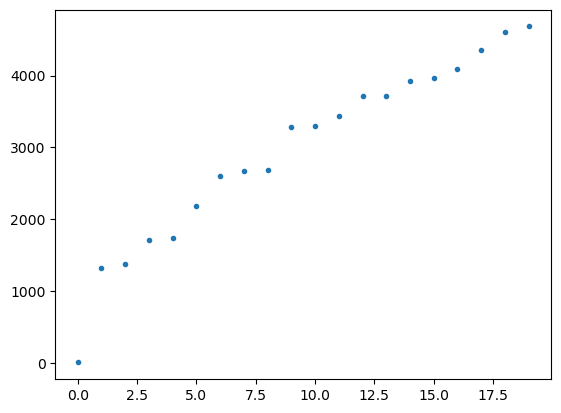

In [115]:
ky = 0
kx = .2103401
nvec = 20
K = fem.Constant(mesh, PETSc.ScalarType((kx,ky)))
eval, evec = solvesys(kx,ky,E,Mcomp,mpc,bcs,nvec, mesh, u_tr, u_test)
eval[np.isclose(eval,0)] == 0
eigfrq_sp_cmp = np.real(eval)**.5
eigfrq_sp_cmp = np.sort(eigfrq_sp_cmp )

plt.plot(eigfrq_sp_cmp,'.')

Now loop through the IBZ to compute a band structure

In [116]:
######################################################################################
#       ---             LOOPING THROUGH THE IBZ              ---                     #
######################################################################################

np1  = 20
np2  = 20
np3  = 20
nvec = 20

ky = 0
tsolve = []
evals_disp =[]
maxk = np.pi/a_len
start=time.time()
evec_all = []
print('Computing Band Structure .... ')
#################################################################
#            Computing K to M                                   #
#################################################################
print('Computing Gamma to  X')
for kx in np.linspace(0.01,maxk,np1):
    K = fem.Constant(mesh, PETSc.ScalarType((kx,ky)))
    eval, evec = solvesys(kx,ky,E,Mcomp,mpc,bcs,nvec, mesh, u_tr, u_test)
    eval[np.isclose(eval,0)] == 0
    eigfrq_sp_cmp = np.real(eval)**.5
    eigfrq_sp_cmp = np.sort(eigfrq_sp_cmp )
    evals_disp.append(eigfrq_sp_cmp )
    evec_all.append(evec)
    
#################################################################
#            Computing K to M                                   #
#################################################################
print('Computing X to  M')
kx = maxk
for ky in np.linspace(0.01,maxk,np2):
    K = fem.Constant(mesh, PETSc.ScalarType((kx,ky)))
    # start=time.time()
    eval, evec = solvesys(kx,ky,E,Mcomp,mpc,bcs,nvec, mesh, u_tr, u_test)
    eval[np.isclose(eval,0)] == 0
    eigfrq_sp_cmp = np.real(eval)**.5
    eigfrq_sp_cmp = np.sort(eigfrq_sp_cmp )
    evals_disp.append(eigfrq_sp_cmp )
    evec_all.append(evec)

#################################################################
#            Computing M To Gamma                               #
#################################################################
print('Computing M to Gamma')
for kx in np.linspace(maxk,0.01,np3):
    ky = kx
    K = fem.Constant(mesh, PETSc.ScalarType((kx,ky)))
    # start=time.time()
    eval, evec = solvesys(kx,ky,E,Mcomp,mpc,bcs,nvec, mesh, u_tr, u_test)
    eval[np.isclose(eval,0)] == 0
    eigfrq_sp_cmp = np.real(eval)**.5
    eigfrq_sp_cmp = np.sort(eigfrq_sp_cmp)
    evals_disp.append(eigfrq_sp_cmp )
    evec_all.append(evec)
    # print(np.round(time.time()-start,3))
# print(np.round(time.time()-start,3))

Computing Band Structure .... 
Computing Gamma to  X
Computing X to  M
Computing M to Gamma


In [117]:
def getbands(bands):
    '''
        Getting the band-gaps from a dispersion diagram
    '''
    evals_disp = bands
    nvec = bands.shape[1]
    nK = bands.shape[0]
    eigfqs      = np.array(evals_disp)
    ef_vec      = eigfqs.reshape((1,nvec*nK))
    evals_all   = np.sort(ef_vec).T
    deval   =   np.diff(evals_all.T).T
    args    =   np.flip(np.argsort(deval.T)).T
    lowlim  = []
    uplim   = []
    bgs     = []

    # =======================
    # Finding the boundaries of the pass bands
    # =======================
    lowb      = []; uppb      = []
    for k in range(nvec):
        lowb.append(np.min(eigfqs.T[k]))
        uppb.append(np.max(eigfqs.T[k]))
    for k in range(nvec):
        LowerLim =  np.max(eigfqs[:,k])
        if k < nvec-1:
            UpperLim =  np.min(eigfqs[:,k+1])
        else:
            UpperLim =  np.min(eigfqs[:,k])
        # =======================
        # Check if these limits fall in a pass band
        # =======================
        overlap = False
        for j in range(nvec):
            if LowerLim > lowb[j] and LowerLim <uppb[j]:
                overlap = True            
            if UpperLim > lowb[j] and UpperLim <uppb[j]:
                overlap = True
        if overlap == False:
            # print('isbg')
            lowlim.append(LowerLim)
            uplim.append(UpperLim)
            bgs.append(UpperLim - LowerLim)
            
    # Filter band gaps
    maxfq           = np.max(eigfqs[:])
    isgap           = [i for i,v in enumerate(bgs) if v > np.median(deval)] 
    gaps            = np.array(bgs)
    lower           = np.array(lowlim)
    higher          = np.array(uplim)
    gapwidths       = gaps[isgap]
    lowbounds       = lower[isgap]
    highbounds      = higher[isgap]
    BG_normalized   = gapwidths/(.5*lowbounds  + .5*highbounds)

    return BG_normalized, gapwidths, gaps, lowbounds, highbounds

<module 'matplotlib.pyplot' from '/home/jrt7/anaconda3/envs/fenicsx-env/lib/python3.10/site-packages/matplotlib/pyplot.py'>

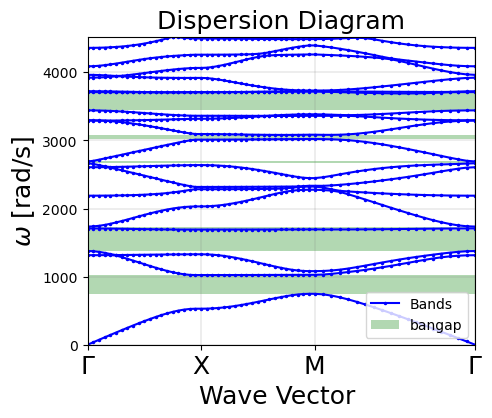

In [118]:

def plotbands(bands, figsize = (5,4)):
    """
    Plot the disprsion bands with bandgaps highlighted on the G-X-M-G boundary
    """ 
    bgnrm, gapwidths, gaps, lowbounds, highbounds = getbands(bands)

    from matplotlib.patches import Rectangle
    plt.figure(figsize=figsize)
    np1 = 20; np2 = 20; np3 = 20
    x1 = np.linspace(0,1-1/np1,np1)
    x2 = np.linspace(1,2-1/np1,np2)
    x3 = np.linspace(2,2+np.sqrt(2),np3)
    xx = np.concatenate((x1,x2,x3))
    nvec = 20
    maxfq = highbounds.max()
    # PLOT THE DISPERSION BANDS
    for n in range(nvec):
        ev = bands[:,n]
        if n == 0:
            plt.plot( xx,(ev),'b.-',markersize = 3, label = 'Bands')
        else:
            plt.plot( xx,(ev),'b.-',markersize = 3)
    plt.grid(color='gray', linestyle='-', linewidth=0.2)
    plt.xticks(np.array([0,1,2,2+np.sqrt(2)]), ['$\Gamma$', 'X', 'M', '$\Gamma$'],fontsize=18)
    plt.xlabel(r'Wave Vector ',fontsize=18)
    plt.ylabel('$\omega$ [rad/s]',fontsize=18)
    plt.title('Dispersion Diagram',fontsize = 18)
    plt.xlim((0,np.max(xx)))
    plt.ylim((0,np.max(maxfq)))
    currentAxis = plt.gca()
    for j in range(len(gapwidths)):
        lb = lowbounds[j]
        ub = highbounds[j]
        if j == 0:
            currentAxis.add_patch( Rectangle((np.min(xx),lb), np.max(xx), ub-lb,  facecolor="g" ,ec='none', alpha =.3,label='bangap'))
        else:
            currentAxis.add_patch( Rectangle((np.min(xx),lb), np.max(xx), ub-lb,  facecolor="g" ,ec='none', alpha =.3))
    plt.legend()
    return plt
plotbands(np.array(evals_disp))

Visualize the eigenvectors

  mycmap = plt.cm.get_cmap('bwr', 20)




No module named 'trame'

Falling back to a static output.
  warnings.warn(



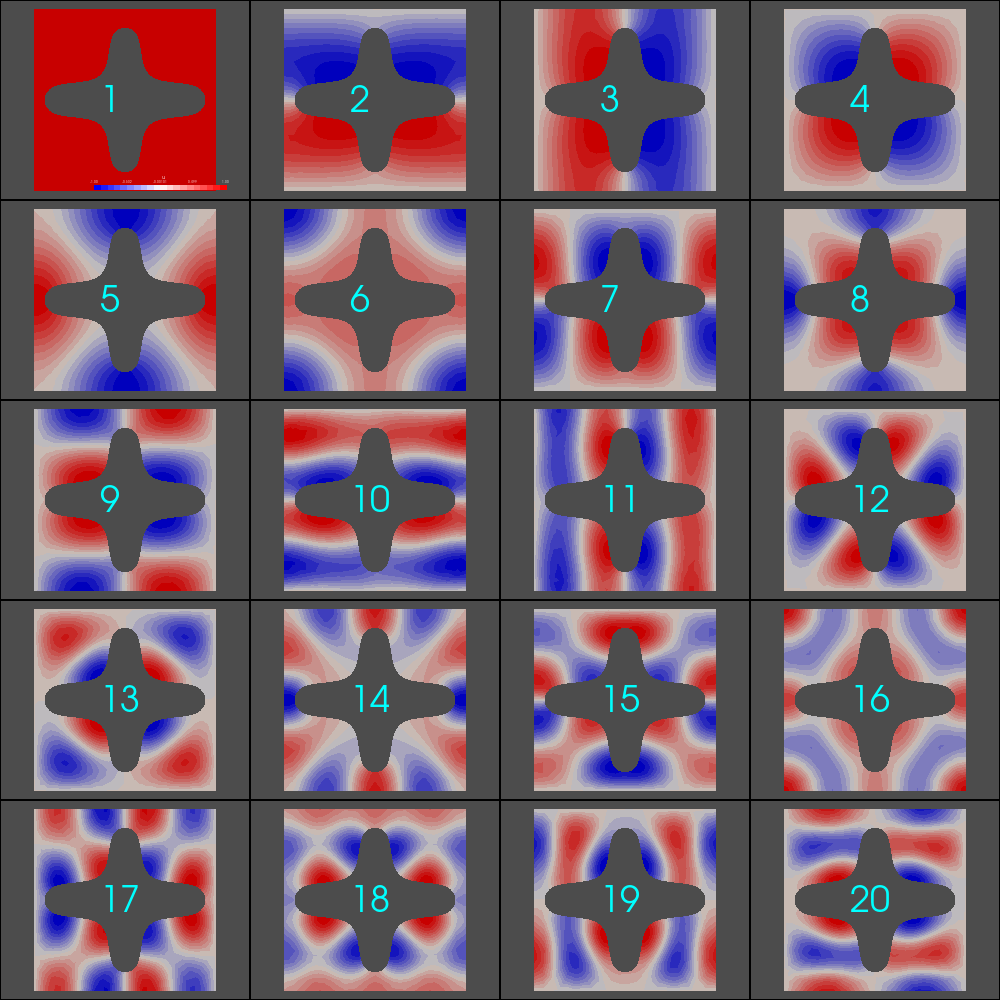

In [120]:
testload = np.array(evec_all) #np.load('data//testFile.npy')
plotter = pyvista.Plotter(shape=(5,4) , window_size=(1000,1000))
###########################################################
# Post-processing the eigenvectors
###########################################################
wnum_use = 44
euse = 0
for i in range(5):
    for j in range(4):
        plotter.subplot(i,j)
        et = testload[0,:,euse]; euse += 1
        vr = Function(V)
        vi = Function(V)
        vr.vector[:] = np.real(et)
        vi.vector[:] = np.imag(et)
        vr.x.scatter_forward()
        mpc.backsubstitution(vr.vector)
        vi.x.scatter_forward()
        mpc.backsubstitution(vi.vector)


        ###########################################################
        # Plotting eigenvectors with pyvista
        ###########################################################
        # mycmap = plt.cm.get_cmap('coolwarm', 10)
        mycmap = plt.cm.get_cmap('bwr', 20)
        u = Function(V)
        cells, types, x = plot.create_vtk_mesh(V)
        grid = pyvista.UnstructuredGrid(cells, types, x)
        grid.point_data["u"] = u.x.array
        u.vector.setArray(vr.vector[:]/np.max(vr.vector[:])*np.sign(vr.vector[10]))
        edges = grid.extract_all_edges()
        warped = grid.warp_by_scalar("u", factor=0)
        plotter.add_mesh(warped, show_edges=False, show_scalar_bar=True, scalars="u",cmap=mycmap)
        # plotter.add_mesh(grid, style = 'wireframe', line_width = .5, color = 'black')
        plotter.view_xy()
        plotter.add_text(str(euse), position=[100,80], color='cyan')
        plotter.camera.tight(padding=0.1)
plotter.show()